In [1]:
import seaborn as sn
from systems import EpicActionRecogintionShapleyClassifier
from datasets.pickle_dataset import MultiPickleDataset
from datasets.hdf5_dataset import HDF5Dataset
from models.esvs import V_MTRN, N_MTRN, V_MF, N_MF
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from frame_sampling import RandomSampler
import pandas as pd
from tqdm import tqdm
from collections import Counter
from scripts.train_mtrn import train_test_loader

In [2]:
def no_collate(args):
    return args
p01_train, p01_test = train_test_loader(MultiPickleDataset('../datasets/epic-100/video_id_features/p01_features.pkl'),batch_size=1,val_split=0.3)

trainloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/67217_train_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=True)
testloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/9668_val_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=False)
# mf_trainloader = DataLoader(HDF5Dataset('../datasets/epic-100/mf_features/audio_slowfast_visual_mformer_features_train.hdf5','../datasets/epic-100/features/67217_train_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=True)
# mf_testloader = DataLoader(HDF5Dataset('../datasets/epic-100/mf_features/audio_slowfast_visual_mformer_features_val.hdf5','../datasets/epic-100/features/9668_val_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=False)

In [ ]:
class V_MTRN(nn.Module):
    
    def __init__(self, frame_count: int):
        super().__init__()
        self.frame_count = frame_count
        self.fc1 = nn.Linear(256 * frame_count, 512)
#         self.fc1_2 = nn.Linear(4096, 1024)
#         self.d1 = nn.Dropout(p=0.7)
#         self.d2 = nn.Dropout(p=0.3)
#         self.fc2 = nn.Linear(1024, 512)
        self.fc2_verb = nn.Linear(512, 97)
    
    def forward(self, x):
        x = x.view(-1, 256 * self.frame_count)
        x = F.relu(self.fc1(x))
#         x = self.d1(x)
#         x = F.relu(self.fc1_2(x))
#         x = self.d2(x)
#         x = F.relu(self.fc2(x))
#         x = self.d2(x)
#         x = self.dropout(x)
        x = self.fc2_verb(x)
        
        return x
    
class N_MTRN(nn.Module):
    
    def __init__(self, frame_count: int):
        super().__init__()
        self.frame_count = frame_count
        self.fc1 = nn.Linear(256 * frame_count, 512)
#         self.d2 = nn.Dropout(p=0.3)
#         self.fc2 = nn.Linear(1024, 512)
        self.fc2_noun = nn.Linear(512, 300)
    
    def forward(self, x):
        x = x.view(-1, 256 * self.frame_count)
        x = F.relu(self.fc1(x))
#         x = self.d1(x)
#         x = F.relu(self.fc1_2(x))
#         x = self.d2(x)
#         x = F.relu(self.fc2(x))
#         x = self.d2(x)
#         x = self.dropout(x)
        x = self.fc2_noun(x)
        
        return x

In [3]:
v_models = [V_MTRN(frame_count=i, hidden_layer_size=1024, dropout_count=2, dropout_probability=0.3) for i in range(1,9)]
# v_model.load_state_dict(torch.load('mtrn_verb_frames=4_lr=1e-4_hl=1024_dc=2.pt', map_location='cpu'))
n_models = [N_MTRN(frame_count=i, hidden_layer_size=1024, dropout_count=2, dropout_probability=0.3) for i in range(1,9)]

# vmf_models = [V_MF(frame_count=i, hidden_layer_size=256, dropout_probability=0.5) for i in range(1,9)]
# nmf_models = [N_MF(frame_count=i, hidden_layer_size=256, dropout_probability=0.5) for i in range(1,9)]
frame_samplers = [RandomSampler(frame_count=i, snippet_length=1, test=False) for i in range(1,9)]

for i in range(len(v_models)):
    try:
        v_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'mtrn-type=verb-frames={i+1}-batch_size=512-lr=1e-05_hl=1024_dc=2_dcp=0.3_epoch=1500.pt', map_location='cpu'))
#         vmf_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'mf-type=verb-frames={i+1}-batch_size=512-lr=1e-05_hl=256_dcp=0.5_epoch=200.pt', map_location='cpu'))
    except FileNotFoundError:
        print(f'no verb model for {i+1} frames')
    try:
        n_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'mtrn-type=noun-frames={i+1}-batch_size=512-lr=1e-05_hl=1024_dc=2_dcp=0.3_epoch=1500.pt', map_location='cpu'))
#         nmf_models[i].load_state_dict(torch.load(Path('../datasets/epic-100/models/') / f'mf-type=noun-frames={i+1}-batch_size=512-lr=1e-05_hl=256_dcp=0.5_epoch=200.pt', map_location='cpu'))
    except FileNotFoundError:
        print(f'no noun model for {i+1} frames')

In [ ]:
p01_models_v = [V_MTRN(frame_count=i) for i in range(1,9)]
p01_models_n = [N_MTRN(frame_count=i) for i in range(1,9)]
frame_samplers = [RandomSampler(frame_count=i, snippet_length=1, test=False) for i in range(1,9)]
for i in range(len(p01_models_n)):
    p01_models_v[i].load_state_dict(torch.load(Path(f'../datasets/epic-100/models/mtrn-frames={i+1}-type=verb.pt'), map_location='cpu'))
    p01_models_n[i].load_state_dict(torch.load(Path(f'../datasets/epic-100/models/mtrn-frames={i+1}-type=noun.pt'), map_location='cpu'))

In [4]:
verbs = pd.read_csv('../datasets/epic-100/labels/EPIC_100_verb_classes.csv')['key'].to_dict()
nouns = pd.read_csv('../datasets/epic-100/labels/EPIC_100_noun_classes.csv')['key'].to_dict()

In [5]:
def get_per_class_accuracy(model, sampler, typ):
    
    def compute_accuracy(preds, labels) -> float:
        return float((labels == preds).sum()) / len(labels)

    if isinstance(model, V_MTRN) or isinstance(model, V_MF):
        classes = verbs
        m_type="verb"
    else:
        classes = nouns
        m_type="noun"
    
    if isinstance(model, V_MF) or isinstance(model, N_MF):
        classifier = EpicActionRecogintionShapleyClassifier(
            model,
            torch.device("cpu"),
            None,
            sampler,
            sampler,
            mf_trainloader,
            mf_testloader,
            m_type
        )
        feature_size=768
    else:
        classifier = EpicActionRecogintionShapleyClassifier(
            model,
            torch.device("cpu"),
            None,
            sampler,
            sampler,
            trainloader,
            testloader,
            m_type
        )
        feature_size=256
    
    correct_pred = {classname: 0 for classname in classes.keys()}
    incorrect_pred = {classname: {class_n: 0 for class_n in classes.keys()} for classname in classes.keys()}
    total_pred = {classname: 0 for classname in classes.keys()}
    
#     print(correct_pred)
#     print(incorrect_pred)
#     print(total_pred)
    
    model.eval()
#     ldr = classifier.testloader if typ
    with torch.no_grad():
        
        validation_results = {
            'loss': [],
            'accuracy': [],
            'preds': [],
            'labels': []
        }
            
        for idx, data in tqdm(enumerate(classifier.testloader if typ=='test' else classifier.trainloader),total=len(classifier.testloader)  if typ=='test' else len(classifier.trainloader),dynamic_ncols=True):
            
            batch, labels = classifier._sample_frames(data)
            
            if idx == 1:
                print(batch.shape)
                print(batch.view(-1,feature_size*model.frame_count).shape)
            
            logits = model(batch.to(torch.device('cpu')))
            preds = logits.argmax(-1).cpu().numpy()
            label_classes = labels[f'{m_type}_class']
            
#             print(f'pred: {preds}, label: {label_classes.cpu().numpy()}')

            for label, pred in zip(label_classes.cpu().numpy(), preds):
                if label == pred:
                    correct_pred[label] += 1
                incorrect_pred[label][pred] += 1
                total_pred[label] += 1
                        
            validation_results['preds'].extend(list(preds))
            validation_results['labels'].extend(list(label_classes.cpu().numpy()))
            
    validation_results['accuracy'] = compute_accuracy(
        np.array(validation_results["labels"]), 
        np.array(validation_results["preds"])
    )
        
        
    print(validation_results['accuracy'])
    
#     print(correct_pred)
#     print(incorrect_pred)
#     print(total_pred)
    
    for classname, correct in correct_pred.items():
        try:
            accuracy = 100 * float(correct) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f}%".format(classes[classname], accuracy))
        except ZeroDivisionError:
            print("Did not predict class {:5s}".format(classes[classname]))
            
    return classes, incorrect_pred

In [6]:
classes, incorrect_pred = get_per_class_accuracy(model=n_models[3], sampler=frame_samplers[3], typ='train')

  0%|          | 0/67217 [00:00<?, ?it/s]

Classifier, model: <class 'models.esvs.N_MTRN'>, type: noun, frames: 4


  0%|          | 2/67217 [00:00<4:39:40,  4.01it/s]

torch.Size([1, 4, 256])
torch.Size([1, 1024])


100%|██████████| 67217/67217 [06:07<00:00, 182.94it/s]


0.4862757933260931
Accuracy for class tap   is: 72.4%
Accuracy for class spoon is: 31.2%
Accuracy for class plate is: 43.1%
Accuracy for class cupboard is: 69.3%
Accuracy for class knife is: 25.8%
Accuracy for class pan   is: 38.2%
Accuracy for class lid   is: 23.0%
Accuracy for class bowl  is: 28.4%
Accuracy for class drawer is: 66.6%
Accuracy for class sponge is: 42.7%
Accuracy for class glass is: 44.3%
Accuracy for class hand  is: 27.7%
Accuracy for class fridge is: 76.1%
Accuracy for class cup   is: 23.5%
Accuracy for class fork  is: 28.8%
Accuracy for class bottle is: 40.7%
Accuracy for class onion is: 64.9%
Accuracy for class cloth is: 44.8%
Accuracy for class board:chopping is: 30.4%
Accuracy for class bag   is: 28.8%
Accuracy for class spatula is: 45.8%
Accuracy for class container is: 42.2%
Accuracy for class liquid:washing is: 36.8%
Accuracy for class box   is: 27.4%
Accuracy for class hob   is: 55.5%
Accuracy for class dough is: 93.0%
Accuracy for class package is: 20.7%
Acc

In [7]:
class_list = list(classes.values())
cnf = np.array([[x for x in y.values()] for y in incorrect_pred.values()])
row_sums = cnf.sum(axis=1)
new_matrix = cnf / row_sums[:, np.newaxis]
new_matrix = np.nan_to_num(new_matrix)

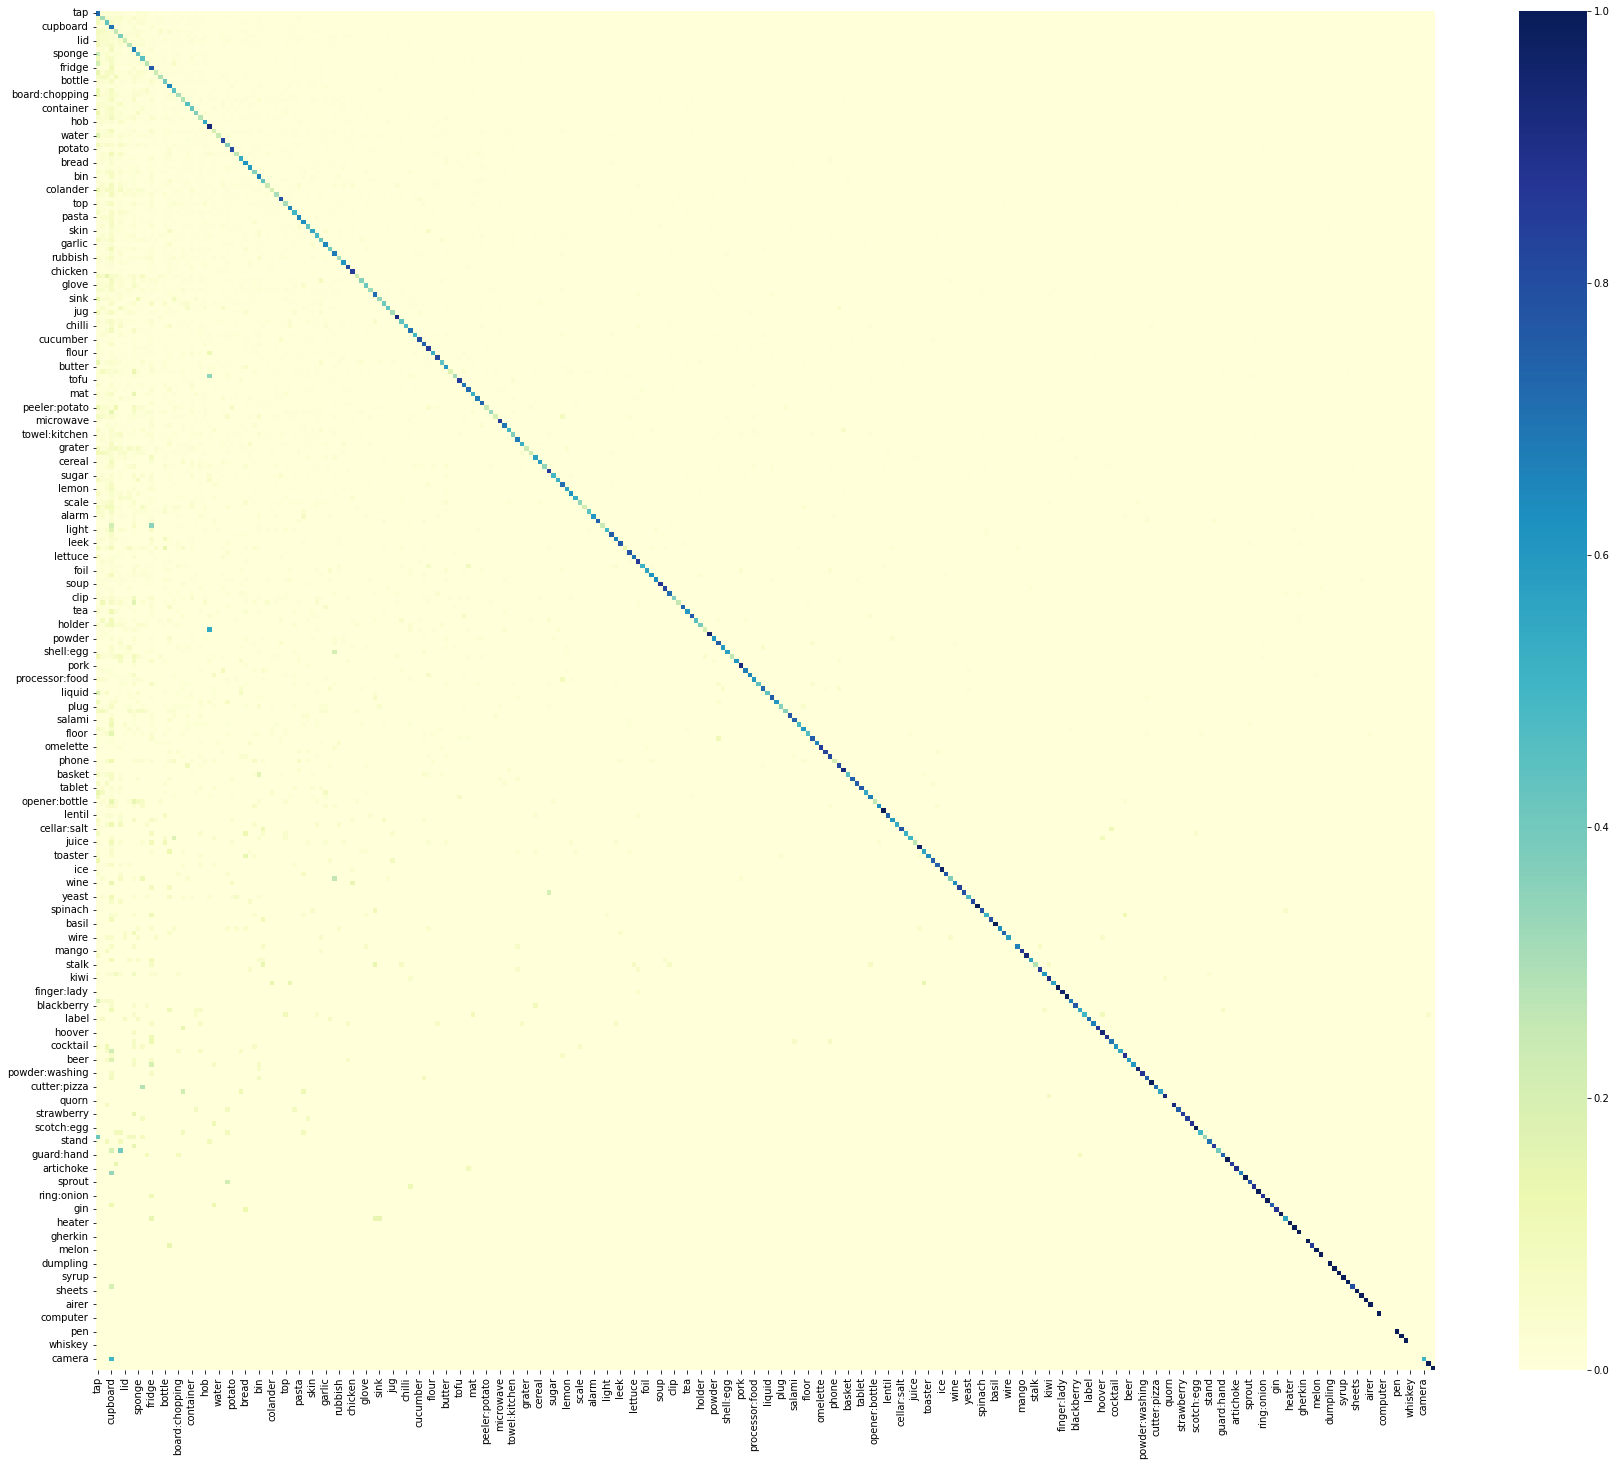

In [8]:
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(new_matrix, index = [i for i in class_list],
                  columns = [i for i in class_list])
plt.figure(figsize = (30,25))
cnf_matrix = sn.heatmap(df_cm, annot=False, cmap="YlGnBu")

In [ ]:
cnf_matrix.get_figure().savefig('conf.png', dpi=72)

In [ ]:
def no_collate(args):
    return args

trainloader_p01 = DataLoader(MultiPickleDataset('../datasets/epic-100/video_id_features/p01_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=True)
trainloader = DataLoader(MultiPickleDataset('../datasets/epic-100/features/67217_train_features.pkl'), batch_size=1, collate_fn=no_collate, shuffle=True)

In [38]:
types = {
    'verb': {
        'name': 'verb',
        'size': 97,
        'cls': verbs,
        'width': 0.4,
        'font': 15
    },
    'noun': {
        'name': 'noun',
        'size': 300,
        'cls': nouns,
        'width': 0.5,
        'font': 7
    }
}
t = types['noun']

t['name']

'noun'

In [39]:
classes_p01 = torch.tensor([p01_test.dataset.pkl_dict['labels'][i]['{name}_class'.format(**t)] for i in p01_train.sampler.indices])
classes = torch.tensor([p01_test.dataset.pkl_dict['labels'][i]['{name}_class'.format(**t)] for i in p01_test.sampler.indices])

classes_train = torch.tensor([label['{name}_class'.format(**t)] for label in trainloader.dataset.pkl_dict['labels']])
classes_test = torch.tensor([label['{name}_class'.format(**t)] for label in testloader.dataset.pkl_dict['labels']])

p01 = torch.tensor(classes_test)#new_cls[:,1])
t1 = torch.tensor(classes_train)

p01_bin = p01.bincount(minlength=t['size'])
t1_bin = t1.bincount(minlength=t['size'])

len(p01)

9668

In [ ]:
def softmax(logits: torch.Tensor) -> torch.Tensor:
    class Log1PlusExp(torch.autograd.Function):
        """Implementation of x ↦ log(1 + exp(x))."""
        @staticmethod
        def forward(ctx, x):
            exp = x.exp()
            ctx.save_for_backward(x)
            return x.where(torch.isinf(exp), exp.log1p())
        @staticmethod
        def backward(ctx, grad_output):
            x, = ctx.saved_tensors
            return grad_output / (1 + (-x).exp())

    log_1_plus_exp = Log1PlusExp.apply

    return (log_1_plus_exp(logits)/(log_1_plus_exp(logits)).sum())

In [ ]:
x = softmax(p01_bin.float())
y = softmax(t1_bin.float())

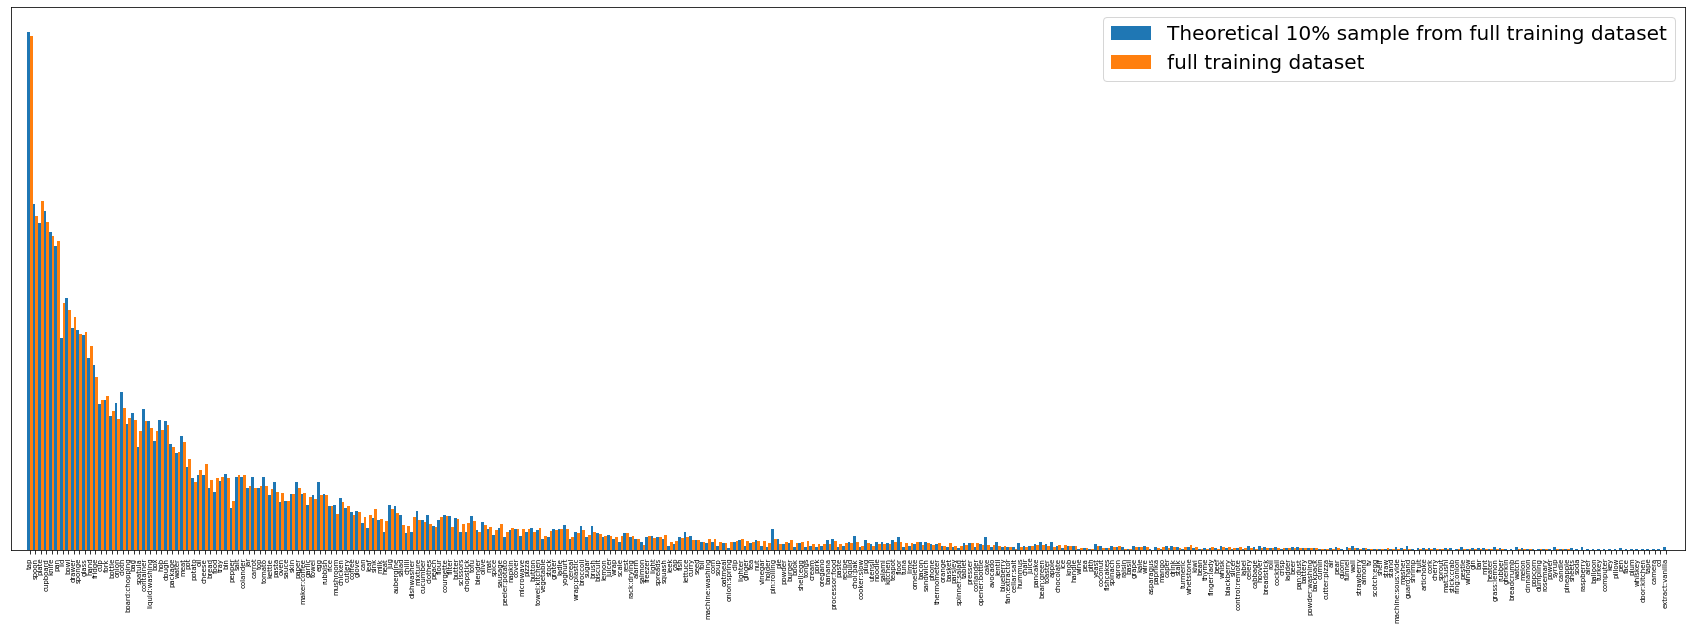

In [179]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,10))

l = np.arange(t['size'])  # the label locations
width = t['width'] # the width of the bars

plt.xticks(l,list(t['cls'].values()),rotation=90,fontsize=t['font'])
plt.yticks([], [])
plt.margins(x=0.01)
ax.bar(l - width/2, x, width, label='Theoretical 10% sample from full training dataset')
ax.bar(l + width/2, y, width, label='full training dataset')
# ax.set_yscale('log')
ax.legend(fontsize=20)
# ax.bar(list(verbs.values()),y)
# ax.bar(list(verbs.values()),x)

In [40]:
# list(verbs.values())
t1_bin.max()*0.1

tensor(361.7000)

In [41]:
torch.where(t1_bin<=t1_bin.max()*0.1)[0].shape

torch.Size([248])

In [42]:
t1_bin.float().mean(), t1_bin.topk(k=5)[0].float().mean()

(tensor(224.0567), tensor(2589.3999))

In [115]:
for label in trainloader.dataset.pkl_dict['labels']:
    if label['participant_id'] in xd:
        xd[label['participant_id']].append((label['verb_class'].item(), label['noun_class'].item()))
    else:
        xd[label['participant_id']] = [(label['verb_class'].item(), label['noun_class'].item())]
        
# for label in testloader.dataset.pkl_dict['labels']:
#     if label['participant_id'] in xd:
#         xd[label['participant_id']].append((label['verb_class'].item(), label['noun_class'].item()))
#     else:
#         xd[label['participant_id']] = [(label['verb_class'].item(), label['noun_class'].item())]

In [116]:
yy = np.array([[i,len(y)] for i, (_,y) in enumerate(xd.items())])

No handles with labels found to put in legend.


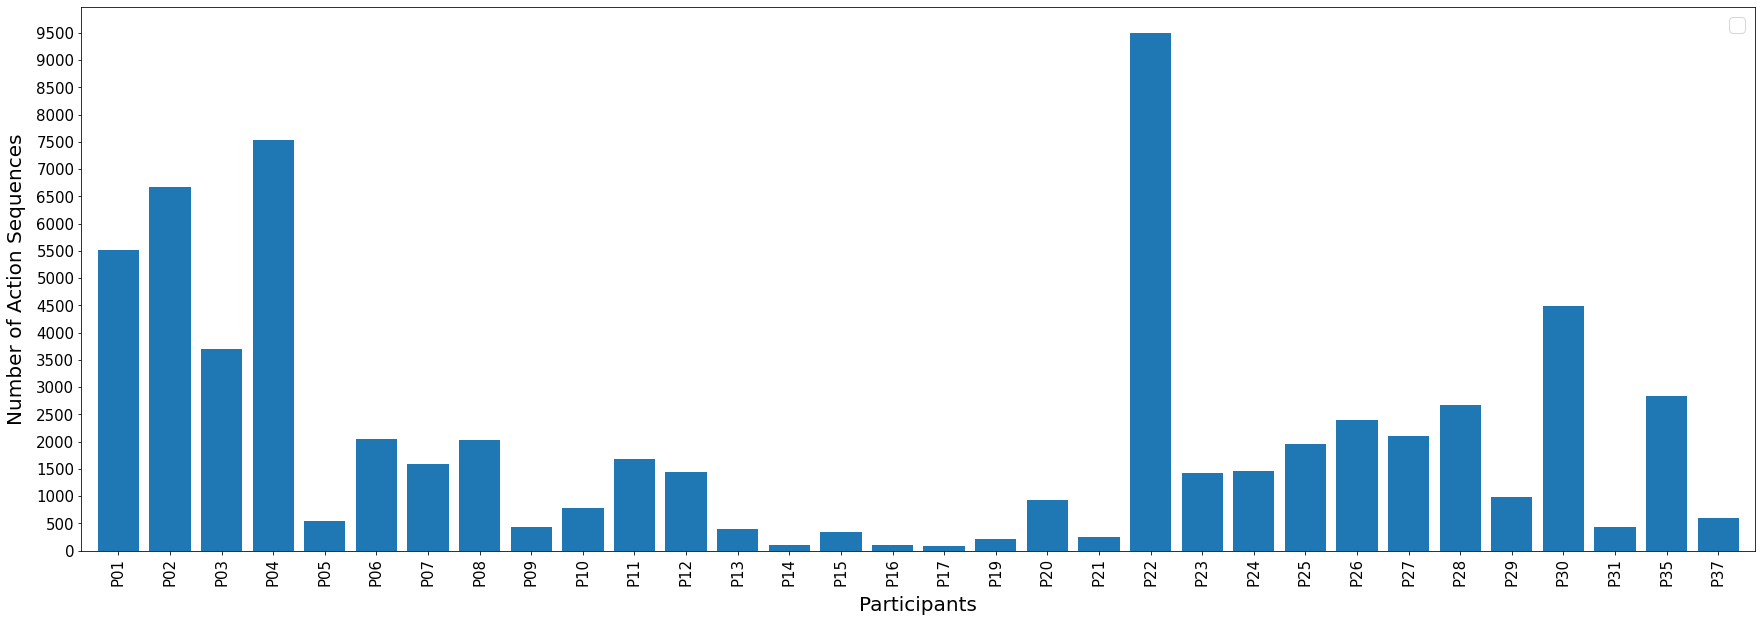

In [117]:
fig, ax = plt.subplots(figsize=(30,10))
plt.margins(x=0.01)
plt.xticks(yy[:,0],list(xd.keys()),rotation=90,fontsize=15)
plt.yticks(np.arange(0,np.max(yy[:,1]),500),fontsize=15)
ax.bar(yy[:,0],yy[:,1])
plt.xlabel('Participants',fontsize=20,labelpad=10)
plt.ylabel('Number of Action Sequences',fontsize=20,labelpad=10)
# ax.set_yscale('log')
ax.legend(fontsize=20)

In [101]:
np.arange(0,np.max(yy[:,1]),500)

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
       5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500])

In [120]:
np.argmin(yy[:,1])

16

In [154]:
len([y for _,x in xd.items() for y in x])

67217

In [121]:
list(xd.keys())[np.argmin(yy[:,1])]

'P17'

In [166]:
sampled_xd = {}

for k,v in xd.items():
    idxs = np.arange(0,len(v))
    np.random.shuffle(idxs)
    sampled = np.array(v)[idxs[:int(np.floor(len(v)*0.1))]]
    sampled_xd[k] = list(map(tuple, sampled))

In [167]:
alie_xd = []
for k,v in sampled_xd.items():
    alie_xd.extend(v)

In [135]:
list(map(tuple,np.array(xd['P01'])[idx[:int(np.floor(len(xd)*0.1))]]))

[(3, 3), (6, 114), (3, 8)]

In [170]:
new_cls = np.array(alie_xd)

In [174]:
new_cls[:,1]

array([  4, 110,  24, ...,  48,  11,  51])

<BarContainer object of 300 artists>

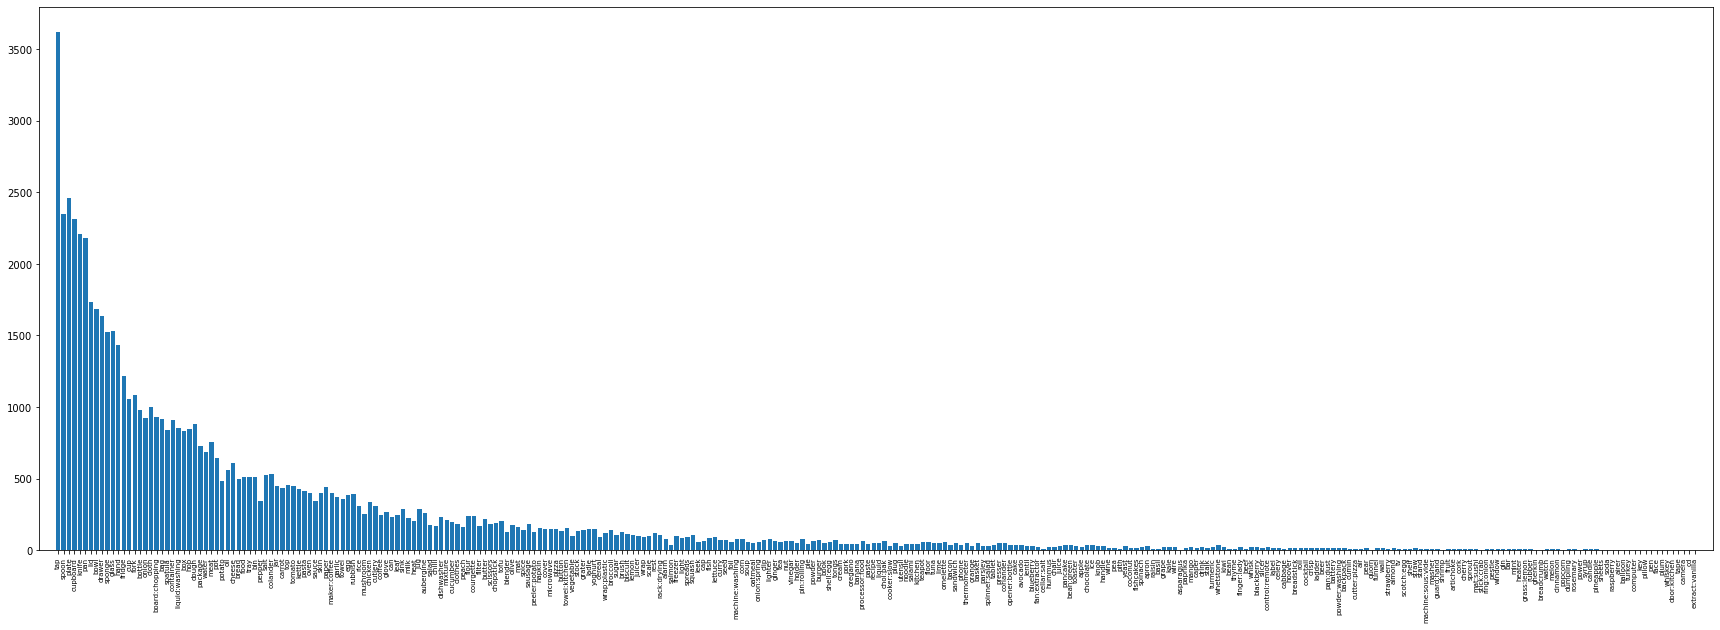

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,10))

l = np.arange(t['size'])  # the label locations
# width = t['width'] # the width of the bars

plt.xticks(l,list(t['cls'].values()),rotation=90,fontsize=t['font'])
# plt.yticks([], [])
plt.margins(x=0.01)
ax.bar(l, t1_bin, label='Theoretical 10% sample from full training dataset')
# ax.bar(l + width/2, y, width, label='full training dataset')
# ax.set_yscale('log')
# ax.legend(fontsize=20)